In [1]:
# Minimal Reproducable Example to check errors
import numpy as np
import h5py
import hdf5plugin
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import integrate


def mass_function(mass, volume, bins, range=None, poisson_uncert=False,
                  return_edges=False, **kwargs):

    if "normed" in kwargs:
        kwargs["normed"] = False
        log.warn("Turned off normed kwarg in mass_function()")

    if (range is not None and (bins in ['blocks',
                                        'knuth', 'knuths',
                                        'scott', 'scotts',
                                        'freedman', 'freedmans'])):
        mass = mass[(mass >= range[0]) & (mass <= range[1])]

    if isinstance(bins, str):
        log.info("Calculating bin widths using `%s' method..." % bins)
        if bins in ['blocks']:
            bins = bayesian_blocks(mass)
        elif bins in ['knuth', 'knuths']:
            dm, bins = knuth_bin_width(mass, True)
        elif bins in ['scott', 'scotts']:
            dm, bins = scotts_bin_width(mass, True)
        elif bins in ['freedman', 'freedmans']:
            dm, bins = freedman_bin_width(mass, True)
        else:
            raise ValueError("unrecognized bin code: '%s'" % bins)
        log.info("...done")

    vals, edges = np.histogram(mass, bins, range, **kwargs)
    width = edges[1]-edges[0]
    radius = width/2.0
    centers = edges[:-1]+radius
    if poisson_uncert:
        uncert = np.sqrt(vals.astype(float))

    # This is the volume normalised part
    vals = vals.astype(float) / (volume * width)

    if not poisson_uncert:
        mf = np.dstack((centers, vals)).squeeze()
    else:
        uncert /= (volume * width)
        mf = np.dstack((centers, vals, uncert)).squeeze()

    if not return_edges:
        return mf
    else:
        return mf, edges

# Assuming they all have the same volume/boxsize

In [2]:
## CV_0/snap_026.hdf5
# Need to use PartType4 Masses for STELLAR Mass, not Halo mass
snap_stars  = '/home/jovyan/Data/Sims/IllustrisTNG/CV/CV_0/snap_026.hdf5'
data = h5py.File(snap_stars, 'r')
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift026     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift026)


Box size:                 25.00 Mpc/h
snapshot redshift:        0.40


In [3]:
# Need to use comoving volume 
#𝑉com=𝑉phys(1+𝑧)3
Vphys = BoxSize**3 
Vcom = Vphys*(1+redshift026)**3 
print('Volume %.2f Mpc^3'%Vphys)
print('Comoving Volume %.2f Mpc^3'%Vcom)

Volume 15625.00 Mpc^3
Comoving Volume 42564.69 Mpc^3


In [4]:
# Function for combining data

In [38]:
import os
import numpy as np
import h5py

def combine_mass_data(filename, snap_file):
    data_directory = '/home/jovyan/Data/Sims/IllustrisTNG/CV/'
    
    # Create an empty list to store mass arrays
    mass_arrays_list = []

    # Initialize redshift to None
    redshift = None

    # Iterate through directories and files
    for folder_name in os.listdir(data_directory):
        folder_path = os.path.join(data_directory, folder_name)

        # Check if it's a directory and its name starts with "CV_"
        if os.path.isdir(folder_path) and folder_name.startswith("CV_"):
            file_path = os.path.join(folder_path, filename)  # Use the provided filename

            # Check if the file exists
            if os.path.isfile(file_path):
                with h5py.File(file_path, 'r') as hdf_file:
                    # Read the mass data from the HDF5 file
                    mass_data = hdf_file['Subhalo/SubhaloMassType'][:,4]
                    
                    # Remove 0 values from the mass data
                    mass_data = mass_data[mass_data != 0]
                    
                    # Append the mass data array to the list
                    # Multiply masses by 10^10 for solar masses
                    mass_data = mass_data*1e10 # log plot instead
                    #mass_data = np.log10(mass_data*1e10) #
                    mass_arrays_list.append(mass_data)
                    
                    # Read redshift from the snapshot file (assuming they are all the same)
                    if redshift is None:
                        snapshot_file = os.path.join(folder_path, snap_file)
                        with h5py.File(snapshot_file, 'r') as snap_data:
                            redshift = snap_data['Header'].attrs[u'Redshift']

    # Combine the mass arrays into one NumPy array
    combined_mass_array = np.concatenate(mass_arrays_list)
    
    return combined_mass_array, redshift


In [39]:
mass_033, z_033 = combine_mass_data('fof_subhalo_tab_033.hdf5', 'snap_033.hdf5')
mass_026, z_026 = combine_mass_data('fof_subhalo_tab_026.hdf5', 'snap_026.hdf5')
mass_013, z_013 = combine_mass_data('fof_subhalo_tab_013.hdf5', 'snap_013.hdf5')

print('mass 033: ', mass_033)
print("z 033: %.3f"%z_033)
print('mass 026: ', mass_026)
print("z 026: %.3f"%z_026)
print('mass 013: ', mass_013)
print("z 013: %.3f"%z_013)


mass 033:  [6.4295463e+11 2.5150487e+10 3.3298905e+10 ... 6.1503985e+06 1.1504983e+07
 7.1605460e+06]
z 033: 0.000
mass 026:  [5.6887155e+11 2.5373471e+10 2.5253368e+10 ... 1.3595555e+07 1.1689762e+07
 1.3671872e+07]
z 026: 0.397
mass 013:  [4.2039493e+11 2.1580329e+10 3.5743138e+10 ... 8.4324250e+06 1.0278613e+07
 1.2515574e+07]
z 013: 1.601


mass_min, mass_max = mass_all026.min(), mass_all026.max()
mass_range = [mass_min, mass_max]
print('Mass Range: ',mass_range)

In [40]:
import numpy as np

def calculate_stellar_mass_function(M, V, nbins):
    """
    Calculate the stellar mass function.

    Parameters:
        logM (array): Array of logarithmic stellar masses.
        V (float): Survey volume in Mpc^3.
        nbins (int): Number of bins for the histogram.

    Returns:
        Max (array): Mass axis.
        Phi (array): Normalized stellar mass function.
    """
    Phi, edg = np.histogram(M, bins=nbins)  # Unnormalized histogram and bin edges
    dM = edg[1] - edg[0]  # Bin size
    Max = edg[:-1] + dM / 2.0  # Mass axis
    Phi = Phi / V / dM  # Normalize to volume and bin size

    return Max, Phi


In [41]:
V = Vcom          # Survey volume in Mpc^3
nbins = 30# Number of bins
#V = BoxSize**3     #Survey volume in Mpc3

Max_033, Phi_033 = calculate_stellar_mass_function(mass_033, V, nbins)
Max_026, Phi_026 = calculate_stellar_mass_function(mass_026, V, nbins)
Max_013, Phi_013 = calculate_stellar_mass_function(mass_013, V, nbins)

# Now you can plot Max and Phi or perform any other desired operations.

Text(0.5, 1.0, 'Stellar Mass Function')

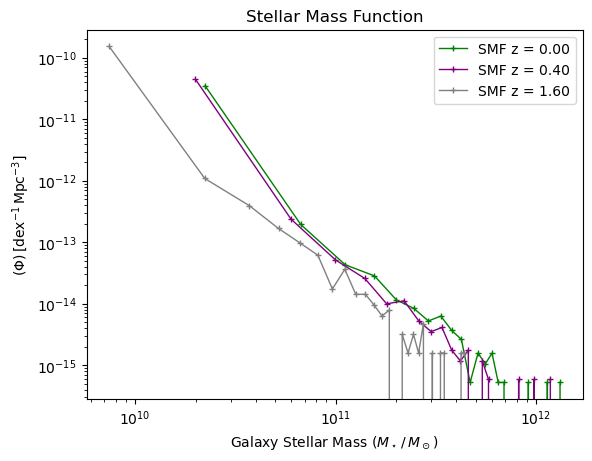

In [47]:
label_033="SMF z = %.2f"%z_033
label_026="SMF z = %.2f"%z_026
label_013="SMF z = %.2f"%z_013

plt.clf()
#plt.xlim(0, np.max(Max))  # Adjust the limits as needed
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.xlabel(r'Galaxy Stellar Mass $(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$(\Phi)\,[\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}]$')
plt.plot(Max_033, Phi_033, linestyle='-', linewidth=1, marker='+', markersize=5, color='green', label=label_033) # np.random.rand(3,)
plt.plot(Max_026, Phi_026, linestyle='-', linewidth=1, marker='+', markersize=5, color='purple', label=label_026)
plt.plot(Max_013, Phi_013, linestyle='-', linewidth=1, marker='+', markersize=5, color='grey', label=label_013)
plt.legend(loc='upper right')  # Add a legend with label for the data
# Set x and y limits
'''
xmin = 1e7
xmax = 1e12
ymin = 1e-6
ymax = 1e1
plt.xlim(xmin, xmax)  # Replace xmin and xmax with your desired x-axis limits
plt.ylim(ymin, ymax)  # Replace ymin and ymax with your desired y-axis limits

'''

plt.title('Stellar Mass Function')  # Add a title to the plot
